In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = ".Data Prepocessing.csv"
df = pd.read_csv(data_path)

df.head()

,platform,country,region,language,category,hashtag,title_keywords,author_handle,sound_type,music_track,...,is_trending,trend_score,country_freq_encoded,country_target_encoded,category_freq_encoded,category_target_encoded,genre_freq_encoded,genre_target_encoded,author_handle_freq_encoded,author_handle_target_encoded
0,TikTok,Jp,Asia,ja,Gaming,#Lifestyle,Night Routine — College,NextVision,trending,8bit loop,...,1,0.646220,0.033029,0.071788,0.051811,0.055801,0.074170,0.067863,0.004534,0.064220
1,TikTok,Se,Europe,sv,Food,#Sports,Morning Routine — College,DailyVlogsDiego,trending,Street vibe,...,0,0.604169,0.034131,0.057282,0.053183,0.069222,0.077809,0.065223,0.000915,0.090909
2,TikTok,Za,Africa,en,Art,#Workout,Night Routine — College,BeyondHub,licensed,Gallery pad,...,0,0.435600,0.032322,0.042471,0.052996,0.062402,0.077809,0.065223,0.004472,0.079070
3,TikTok,Kr,Asia,ko,News,#Esports,Best Settings for Fortnite,NextHub,original,Neutral piano,...,0,0.583289,0.033341,0.065502,0.052559,0.057380,0.076561,0.062483,0.003973,0.041885
4,TikTok,Au,Oceania,en,Beauty,#Comedy,When your friend is Beginners,LucasOfficial,licensed,Soft glam loop,...,0,0.491961,0.032093,0.066753,0.052851,0.063361,0.076707,0.063178,0.001747,0.035714


In [3]:
# featuring engineering

df["views_w"] = df["views"] / 10000

target_col = "views_w"

numeric_features = [
    "duration_sec",        
    "title_length",        
    "creator_avg_views",   
    "avg_watch_time_sec",  

    
    "likes",
    "comments",
    "shares",
    "saves",
    "dislikes",
]


categorical_features = [
    #"country",
    #"region",
    #"language",
    "category",
    "genre",
    #"creator_tier",
    "has_emoji",       
    "upload_hour",    
    "event_season",
    "is_weekend",      
    "traffic_source",
]

candidate_features = numeric_features + categorical_features
print(len(candidate_features))

16


In [4]:
# df_model data set
use_cols = ["platform", target_col] + candidate_features
df_model = df[use_cols].copy()

# drop na
df_model = df_model.dropna()
print(df_model.shape)


print(df_model["platform"].value_counts())

(48079, 18)
platform
TikTok     28844
YouTube    19235
Name: count, dtype: int64


In [5]:
df_tiktok = df_model[df_model["platform"] == "TikTok"].copy()
df_youtube = df_model[df_model["platform"] == "YouTube"].copy()

print(df_tiktok.shape)
print( df_youtube.shape)

(28844, 18)
(19235, 18)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# TikTok  X / y
X_tt = df_tiktok[candidate_features]
y_tt = df_tiktok[target_col].values

# data set split
X_tt_train, X_tt_test, y_tt_train, y_tt_test = train_test_split(
    X_tt, y_tt, test_size=0.2, random_state=42
)

# data preprocessing: StandardScaler()+OneHotEncoder
preprocessor_tt = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_tt_train_proc = preprocessor_tt.fit_transform(X_tt_train)
X_tt_test_proc = preprocessor_tt.transform(X_tt_test)

# dense
if hasattr(X_tt_train_proc, "toarray"):
    X_tt_train_proc = X_tt_train_proc.toarray()
    X_tt_test_proc = X_tt_test_proc.toarray()

# One-Hot name
feature_names_tt = preprocessor_tt.get_feature_names_out()
len(feature_names_tt)


79

In [7]:
# youtube

X_yt = df_youtube[candidate_features]
y_yt = df_youtube[target_col].values

# train/test
X_yt_train, X_yt_test, y_yt_train, y_yt_test = train_test_split(
    X_yt, y_yt, test_size=0.2, random_state=42
)


preprocessor_yt = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_yt_train_proc = preprocessor_yt.fit_transform(X_yt_train)
X_yt_test_proc = preprocessor_yt.transform(X_yt_test)

if hasattr(X_yt_train_proc, "toarray"):
    X_yt_train_proc = X_yt_train_proc.toarray()
    X_yt_test_proc = X_yt_test_proc.toarray()

feature_names_yt = preprocessor_yt.get_feature_names_out()
len(feature_names_yt)

79

In [8]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def compute_metrics(y_true, y_pred):
   
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"R2": r2, "RMSE": rmse, "MAE": mae, "MSE": mse}


def train_plot_model(X_train, X_test, y_train, y_test,
                     feature_names, model, model_name,
                     platform_name, top_n=10):
 
    # trainging
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # metrics
    metrics_train = compute_metrics(y_train, y_train_pred)
    metrics_test = compute_metrics(y_test, y_test_pred)

    print(f"\n{platform_name} - {model_name}")
    print("Train:", metrics_train)
    print("Test :", metrics_test)

    # fitting plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train, y_train_pred, alpha=0.3, label="Train")
    plt.scatter(y_test, y_test_pred, alpha=0.5, label="Test")

    min_val = min(y_train.min(), y_test.min(),
                  y_train_pred.min(), y_test_pred.min())
    max_val = max(y_train.max(), y_test.max(),
                  y_train_pred.max(), y_test_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "k--")

    plt.xlabel("True views")
    plt.ylabel("Predicted views")
    plt.title(f"{platform_name} - {model_name}: Prediction fit")

    textstr = (
        f"Train: R2={metrics_train['R2']:.3f}, "
        f"RMSE={metrics_train['RMSE']:.3f}\n"
        f"       MAE={metrics_train['MAE']:.3f}, "
        f"MSE={metrics_train['MSE']:.3f}\n"
        f"Test:  R2={metrics_test['R2']:.3f}, "
        f"RMSE={metrics_test['RMSE']:.3f}\n"
        f"       MAE={metrics_test['MAE']:.3f}, "
        f"MSE={metrics_test['MSE']:.3f}"
    )

    plt.gcf().text(0.02, 0.98, textstr,
                   ha="left", va="top", fontsize=8,
                   bbox=dict(boxstyle="round", alpha=0.15))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # feature importance
    if hasattr(model, "coef_"):
        importance = np.abs(model.coef_)  
    elif hasattr(model, "feature_importances_"):
        importance = model.feature_importances_  
    else:
        importance = None

    if importance is not None:
        imp_df = (
            pd.DataFrame({"feature": feature_names, "importance": importance})
            .sort_values("importance", ascending=False)
        )
        top_df = imp_df.head(top_n).iloc[::-1]  

        print(f"\n{platform_name} - {model_name} Top {top_n} features:")
        print(top_df.iloc[::-1].reset_index(drop=True))  

        plt.figure(figsize=(8, 4))
        plt.barh(top_df["feature"], top_df["importance"])
        plt.xlabel("Importance")
        plt.title(f"{platform_name} - {model_name}: Top {top_n} features")
        plt.tight_layout()
        plt.show()
    else:
        imp_df = None

    return metrics_test, imp_df

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor  


model_builders = {
    "Linear": lambda: LinearRegression(),
    "RandomForest": lambda: RandomForestRegressor(
        n_estimators=300,
        random_state=8965,
        n_jobs=-1,
        max_depth=None
    ),
    "XGBoost": lambda: XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=8965,
        n_jobs=-1
    ),
}


TikTok - Linear
Train: {'R2': 0.8952133535423272, 'RMSE': np.float64(2.3149925446572257), 'MAE': 1.60972309332444, 'MSE': 5.359190481818538}
Test : {'R2': 0.8970003928334566, 'RMSE': np.float64(2.327261100334712), 'MAE': 1.630818926855347, 'MSE': 5.416144229131135}


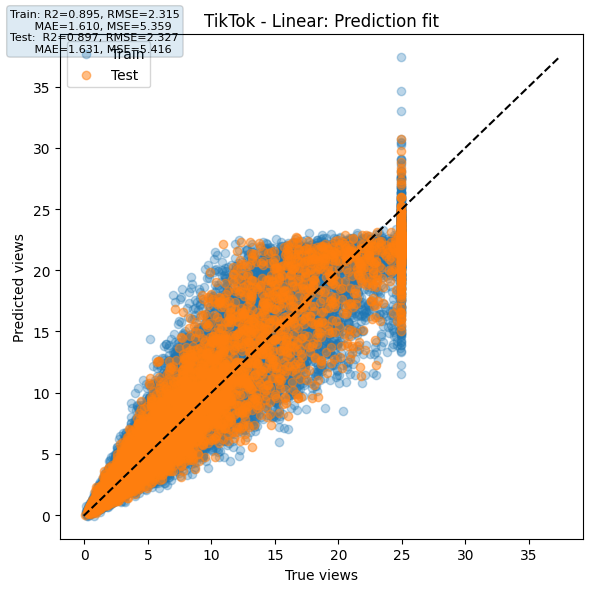


TikTok - Linear Top 10 features:
                     feature  importance
0                 num__likes    4.373168
1              num__comments    0.818967
2                 num__saves    0.794009
3                num__shares    0.551283
4              num__dislikes    0.529314
5         cat__upload_hour_2    0.281874
6        cat__upload_hour_10    0.238670
7         cat__upload_hour_0    0.188077
8  cat__event_season_Ramadan    0.165948
9         cat__upload_hour_8    0.160222


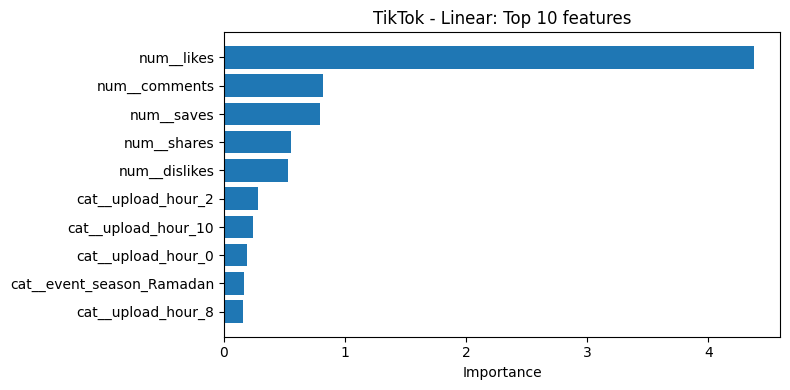


TikTok - RandomForest
Train: {'R2': 0.9861433688558955, 'RMSE': np.float64(0.8418320462550006), 'MAE': 0.5623199193066022, 'MSE': 0.7086811941018815}
Test : {'R2': 0.901271037066452, 'RMSE': np.float64(2.278503047726597), 'MAE': 1.5277879620962571, 'MSE': 5.191576138499391}


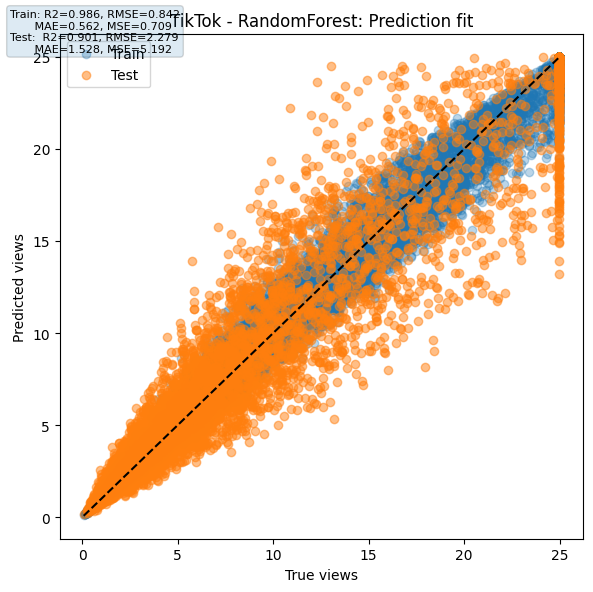


TikTok - RandomForest Top 10 features:
                     feature  importance
0                 num__likes    0.901815
1                 num__saves    0.012480
2              num__dislikes    0.009730
3              num__comments    0.009419
4     num__creator_avg_views    0.008364
5                num__shares    0.008288
6    num__avg_watch_time_sec    0.006840
7          num__title_length    0.005290
8          num__duration_sec    0.005168
9  cat__event_season_Regular    0.000865


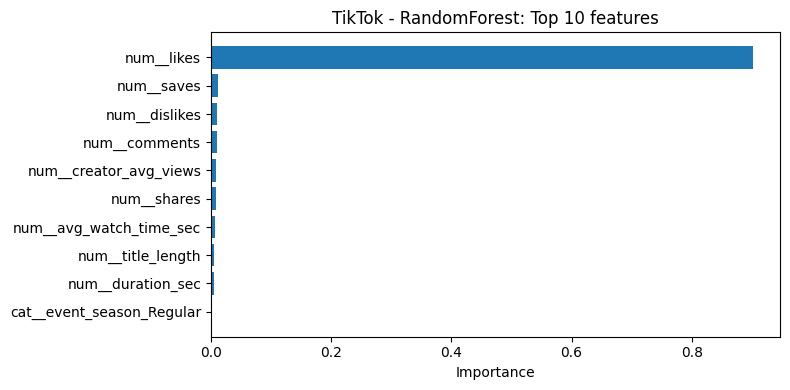


TikTok - XGBoost
Train: {'R2': 0.9605120748779826, 'RMSE': np.float64(1.4211135591509134), 'MAE': 1.0226806144659946, 'MSE': 2.019563748002577}
Test : {'R2': 0.8962831167087171, 'RMSE': np.float64(2.3353504162352388), 'MAE': 1.5568264742847537, 'MSE': 5.453861566610103}


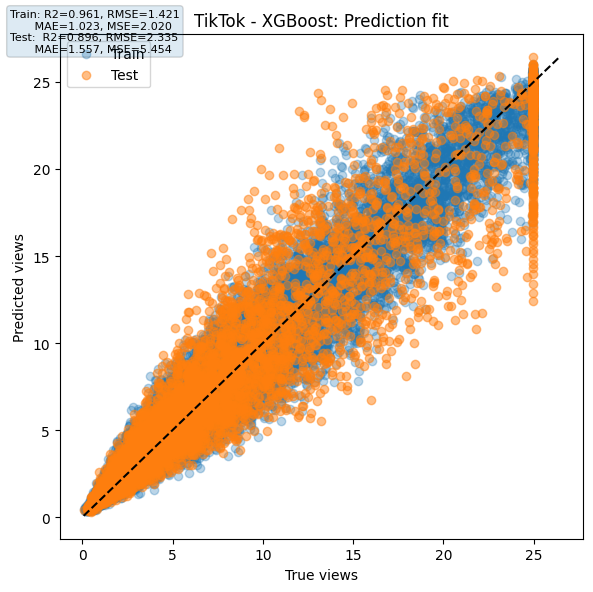


TikTok - XGBoost Top 10 features:
                     feature  importance
0                 num__likes    0.542954
1                num__shares    0.067070
2                 num__saves    0.009743
3         cat__upload_hour_0    0.007936
4              num__comments    0.007757
5          cat__genre_Gaming    0.006605
6  cat__event_season_Ramadan    0.006489
7        cat__upload_hour_17    0.006403
8        cat__upload_hour_23    0.006324
9       cat__genre_Education    0.006162


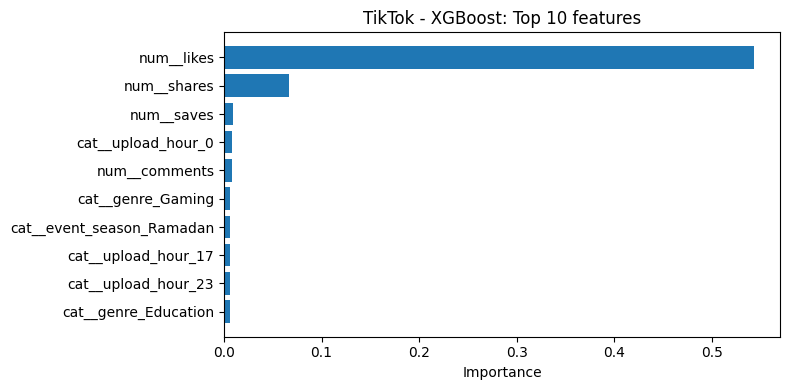

  platform         model        R2      RMSE       MAE       MSE
0   TikTok        Linear  0.897000  2.327261  1.630819  5.416144
1   TikTok  RandomForest  0.901271  2.278503  1.527788  5.191576
2   TikTok       XGBoost  0.896283  2.335350  1.556826  5.453862


In [10]:
tiktok_results_rows = []   
tiktok_importances = {}   
tiktok_trained_models = {}

for model_name, builder in model_builders.items():
    model = builder()
    metrics_test, imp_df = train_plot_model(
        X_tt_train_proc, X_tt_test_proc,
        y_tt_train, y_tt_test,
        feature_names_tt,
        model=model,
        model_name=model_name,
        platform_name="TikTok",
        top_n=10
    )
    row = {"platform": "TikTok", "model": model_name}
    row.update(metrics_test)
    tiktok_results_rows.append(row)
    tiktok_importances[model_name] = imp_df
    
    tiktok_trained_models[model_name] = model

tiktok_results = pd.DataFrame(tiktok_results_rows)

print(tiktok_results)


YouTube - Linear
Train: {'R2': 0.8541721388477015, 'RMSE': np.float64(2.723936877014185), 'MAE': 1.9359838535732652, 'MSE': 7.419832109957791}
Test : {'R2': 0.848359164035373, 'RMSE': np.float64(2.789706792191592), 'MAE': 1.9793497987804978, 'MSE': 7.782463986399903}


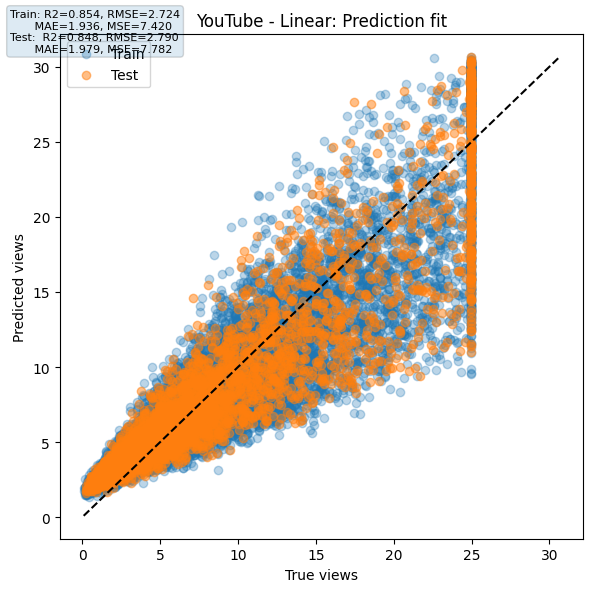


YouTube - Linear Top 10 features:
                 feature  importance
0             num__likes    4.796962
1          num__comments    0.909737
2             num__saves    0.779663
3            num__shares    0.618156
4          num__dislikes    0.535207
5     cat__upload_hour_4    0.513258
6     cat__upload_hour_6    0.447026
7  cat__category_Finance    0.280908
8     cat__upload_hour_9    0.253398
9     cat__upload_hour_2    0.221422


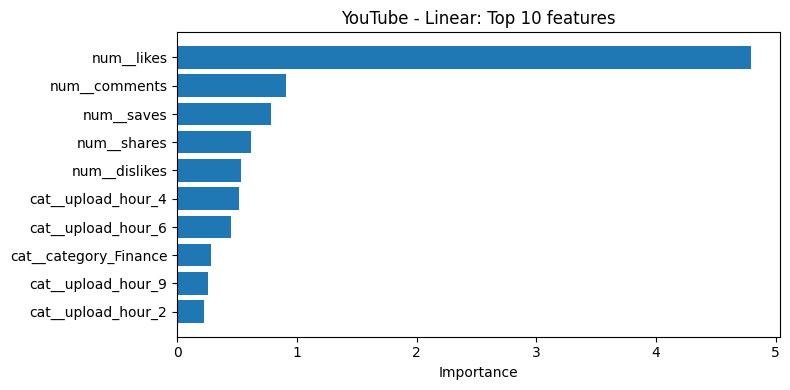


YouTube - RandomForest
Train: {'R2': 0.9836062107626998, 'RMSE': np.float64(0.9133063136483583), 'MAE': 0.6118049152586382, 'MSE': 0.8341284225499536}
Test : {'R2': 0.87755957105033, 'RMSE': np.float64(2.5067608077865837), 'MAE': 1.7055023902174822, 'MSE': 6.283849747454846}


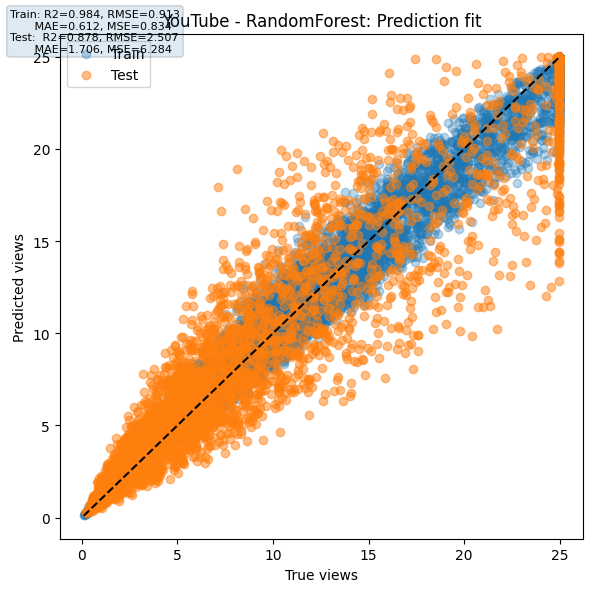


YouTube - RandomForest Top 10 features:
                    feature  importance
0                num__likes    0.893680
1                num__saves    0.010311
2             num__comments    0.010273
3             num__dislikes    0.009524
4               num__shares    0.009374
5    num__creator_avg_views    0.009371
6   num__avg_watch_time_sec    0.008408
7         num__duration_sec    0.006298
8         num__title_length    0.005905
9  cat__traffic_source_Home    0.001050


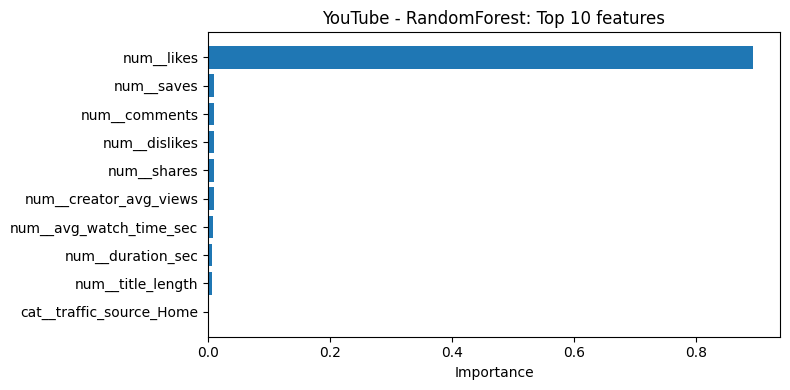


YouTube - XGBoost
Train: {'R2': 0.9652015472072637, 'RMSE': np.float64(1.3306282931788906), 'MAE': 0.975633105265208, 'MSE': 1.770571654608168}
Test : {'R2': 0.8689790701617248, 'RMSE': np.float64(2.593109244664715), 'MAE': 1.7530845141734213, 'MSE': 6.724215554765608}


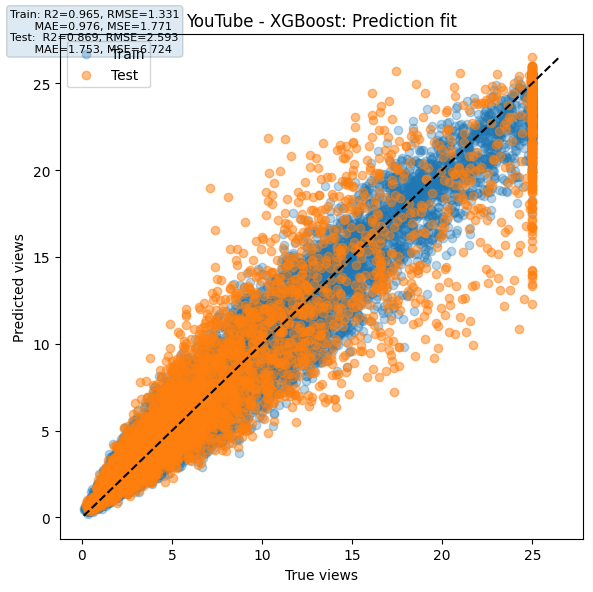


YouTube - XGBoost Top 10 features:
                 feature  importance
0             num__likes    0.433195
1            num__shares    0.061420
2     cat__genre_Fashion    0.009964
3  cat__category_Finance    0.009498
4    cat__upload_hour_11    0.009175
5    cat__upload_hour_18    0.009136
6          num__comments    0.008907
7    cat__upload_hour_16    0.008409
8             num__saves    0.008222
9   cat__genre_Lifestyle    0.008100


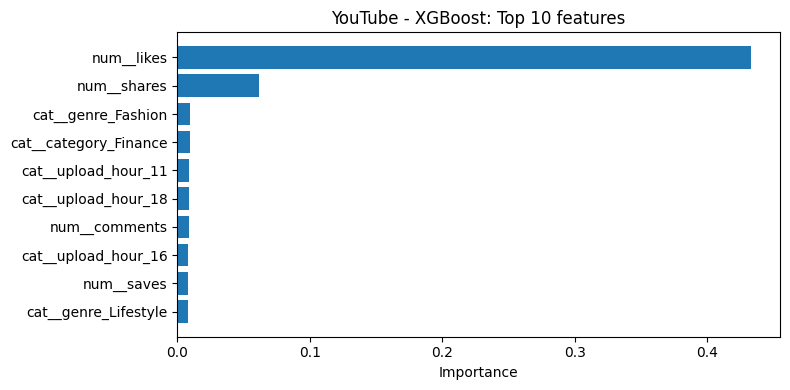

  platform         model        R2      RMSE       MAE       MSE
0  YouTube        Linear  0.848359  2.789707  1.979350  7.782464
1  YouTube  RandomForest  0.877560  2.506761  1.705502  6.283850
2  YouTube       XGBoost  0.868979  2.593109  1.753085  6.724216


In [11]:
youtube_results_rows = []
youtube_importances = {}
youtube_trained_models = {}  

for model_name, builder in model_builders.items():
    model = builder()
    metrics_test, imp_df = train_plot_model(
        X_yt_train_proc, X_yt_test_proc,
        y_yt_train, y_yt_test,
        feature_names_yt,
        model=model,
        model_name=model_name,
        platform_name="YouTube",
        top_n=10
    )
    row = {"platform": "YouTube", "model": model_name}
    row.update(metrics_test)
    youtube_results_rows.append(row)
    youtube_importances[model_name] = imp_df

    youtube_trained_models[model_name] = model

youtube_results = pd.DataFrame(youtube_results_rows)

print(youtube_results)

In [4]:
import pandas as pd

data = {
    "Platform": ["TikTok", "TikTok", "TikTok",
                 "YouTube", "YouTube", "YouTube"],
    "Model": ["Linear", "RandomForest", "XGBoost",
              "Linear", "RandomForest", "XGBoost"],
    "R2":   [0.897000, 0.901271, 0.896283,
             0.848359, 0.877560, 0.868979],
    "RMSE": [2.327261, 2.278503, 2.335350,
             2.789707, 2.506761, 2.593109],
    "MAE":  [1.630819, 1.527788, 1.556826,
             1.979350, 1.705502, 1.753085],
    "MSE":  [5.416144, 5.191576, 5.453862,
             7.782464, 6.283850, 6.724216],
}

df0 = pd.DataFrame(data)
df0 = df0[["Platform", "Model", "R2", "RMSE", "MAE", "MSE"]]


metrics = ["R2", "RMSE", "MAE", "MSE"]
col_max = {m: df0[m].max() for m in metrics}


styled = (
    df0.style
    .format({
        "R2": "{:.3f}",
        "RMSE": "{:.3f}",
        "MAE": "{:.3f}",
        "MSE": "{:.3f}",
    })
    
    .bar(subset=["R2"],
         color="#4C72B0",
         vmin=0.8,
         #vmax=1,
         vmax=col_max["R2"],
         align="left")
    

    .bar(subset=["RMSE"],
         color="#55A868",
         vmin=0,
         vmax=col_max["RMSE"],
         align="left")
    

    .bar(subset=["MAE"],
         color="#C44E52",
         vmin=0,
         vmax=col_max["MAE"],
         align="left")
    

    .bar(subset=["MSE"],
         color="#8172B3",
         vmin=0,
         vmax=col_max["MSE"],
         align="left")
)


styled.to_html("model_metrics_bars.html")
styled

,Platform,Model,R2,RMSE,MAE,MSE
0,TikTok,Linear,0.897,2.327,1.631,5.416
1,TikTok,RandomForest,0.901,2.279,1.528,5.192
2,TikTok,XGBoost,0.896,2.335,1.557,5.454
3,YouTube,Linear,0.848,2.790,1.979,7.782
4,YouTube,RandomForest,0.878,2.507,1.706,6.284
5,YouTube,XGBoost,0.869,2.593,1.753,6.724
